In [1]:
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from fastai.vision.all import URLs
from batchflow import Pipeline, B, C, D, F, V, W
from batchflow.models.torch import EncoderDecoder
from batchflow.models.torch.layers import ConvBlock
from batchflow.models.torch.layers.modules import ASPP, PyramidPooling, KSAC
from batchflow.opensets import Imagenette160

from train_module import training_functions

GRAPH_PATH = "./data/graphs/"
IMAGE_SHAPE = (3, 160, 160)

In [2]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [3]:
dataset = Imagenette160(bar='n')

 50%|█████     | 1/2 [00:05<00:05,  5.27s/it]


In [4]:
in_channels = 3
out_channels = 3
device = "cuda:3"

batch_size = 64
epoch_num = 5

In [8]:
downsample_depth = 2
in_channels = 3
model_config = { 
    'device': device,
    'inputs/images/shape': (3, 160, 160), # can be commented
    'initial_block/inputs': 'images', # can be commented   
    'initial_block': {
        'layout': 'cna cna',
        'strides': [2, 1],
        'filters': [32, 64]
    },

    'body/encoder': {
        'num_stages': downsample_depth,
        'order': ['downsampling', 'skip']
    },    
    'body/encoder/downsample': {
        'layout': 'R' + 'wnacna' * 3 + '|',
        'filters': 'same',
        'strides': [[1, 1, 1, 1, 2, 1]] * downsample_depth,
        'kernel_size': [[3, 1] * 3] * downsample_depth,
        'dilation_rate' : 2,
        'branch': {
            'layout': 'cn', 
            'kernel_size': 1,
            'filters': 'same',
            'strides': 2
        },
    },      

    'body/embedding': {
        'base' : ASPP
    },  

    'body/decoder': {
        'num_stages': downsample_depth,
        'order': ['block', 'combine', 'upsampling'] 
    },

    'body/decoder/blocks': {
        'layout': 'cna',
        'kernel_size': 1,
        'filters': 256
    },

    'body/decoder/upsample': {
        'layout': 'b',
        'scale_factor': 2
    },
    'body/decoder/combine': {
        'op': 'concat',
    },
    
    
    'head':{
        'layout': 'cna b',
        'scale_factor': 2,
        'filters': in_channels,
        'activation': 'sigmoid'
    },

    'loss': 'mse',
    'optimizer': 'Adam'
}

In [10]:
train_pipeline = (dataset.train.p
                .crop(shape=(160, 160), origin='center')
                .init_variable('loss_history', [])
                .to_array(channels='first', dtype=np.float32)
                .multiply(1./255)
                .init_model('dynamic', EncoderDecoder, 'unet',
                            config=model_config)
                .train_model('unet', B.images, B.images, 
                             fetches='loss', save_to=V('loss_history', mode='a'), use_lock=True)
)

In [11]:
train_pipeline.run(64, n_epochs=5, bar='n', shuffle=True)

  0%|                                                                                                         …

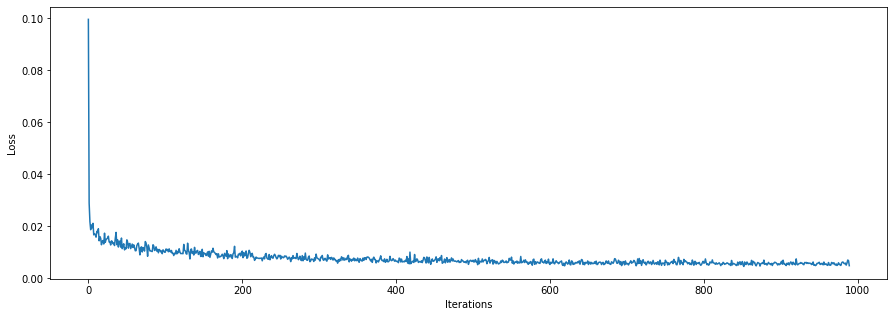

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(train_pipeline.v('loss_history'))
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

In [13]:
pipeline = (dataset.test.p
                .crop(shape=(160, 160), origin='center')
                .to_array(channels='first', dtype=np.float32)
                .multiply(1./255)
                .init_variable('metrics')
                .init_variable('inferred_masks')
                .import_model('unet', train_pipeline)
                .predict_model('unet', fetches='predictions', feed_dict={'x': B('images')},
                               save_to=V('inferred_masks'))
                .gather_metrics('mask', targets=B('images'), predictions=V('inferred_masks'),
                                fmt='proba', axis=-1, save_to=V('metrics', mode='u'))
            )

In [14]:
pipeline.run(64, bar='n')

  0%|                                                                                                         …

In [21]:
batch = pipeline.next_batch(3)
outputs = pipeline.v('inferred_masks')[:3]

In [58]:
type(outputs[0][0,0,0])

numpy.float16

In [63]:
type(batch.images[0][0,0,0])

numpy.float64

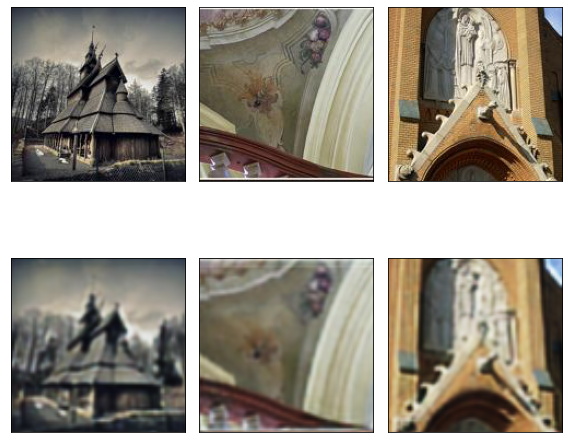

In [66]:
batch = pipeline.next_batch(3)
outputs = pipeline.v('inferred_masks')[:3]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})

for picture_num, ax in enumerate(axs.flat):
    if picture_num<3:        
        ax.imshow(np.moveaxis(batch.images[picture_num], 0, -1))
    else:
        ax.imshow(np.moveaxis(outputs[picture_num-3].astype('float64'), 0, -1))


plt.tight_layout()
plt.show()